Étape 1 : 

        Il nous faut construire l'état de superposition uniforme grâce à la procédure d'amplification des amplitudes, qui peut être facilement construit en appliquant des opérateurs d'Hadamard.

        Cependant cet état que l'on nommera |s⟩ n'est pas exactement perpendiculaire à l'état recherché |w⟩, or cet état que l'on cherche à ateindre a une probabilité de 1/√N d'apparaitre. Nous pouvons définir un nouvel état que nous nommerons  |s'⟩ qui est perpendiculaire à l'état que l'on recherche.

        Par une représentation géographique, nous avons un décalage angulaire de θ entre |s⟩ et |s'⟩.


Étape 2 : 

        On applique l'oracle de réflexion à l'aide de Uf à l'état |s⟩, pour obtenir un nouvel état "intermédiaire" qui est la symétrie de |s⟩ par rapport à |s'⟩.

Étape 3 :

        Et pour finir, nous appliquons une rélfexion noté Us de l'état intermédiaire par rapport à son état initial (dans notre cas c'est encore |s⟩).


L'ensemble des opérations est appelé le diffuseur.
Pour certain cas, nous devons réappliquer le Diffuseur autant de fois que nécessaire pour se rapprocher de l'état que nous recherchons.

Cependant, si nous appliquons trop de fois le Diffuseur, nous pouvons nous éloigner de notre état recherché.

In [45]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram


Nous commençons par créer un circuit de 2 qubits 

In [46]:
n = 2
grover_circuit = QuantumCircuit(n)


Nous commençons par initialiser l'état de |s⟩. Nous créons au passage une fonction d'initialisation qui nous permettra de la réutiliser plus tard.

In [47]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc


In [48]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()


┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

Appliquons l'oracle pour |w⟩=|11⟩

In [49]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()


┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

Dans la suite, nous appliquons le diffuseur qui nous permettra de nous rapprocher de l'état recherché.

In [50]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()


┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

En appliquant ce circuit à l'aide du simulateur nous pouvons vérifier le bon état vectoriel.

In [51]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")


<IPython.core.display.Math object>

Comme attendu, l'amplitude de tous les états qui ne sont pas égals à |11⟩ est de 0. 

Ce qui implique que nous avons 100% de mesurer l'état recherché |11⟩.

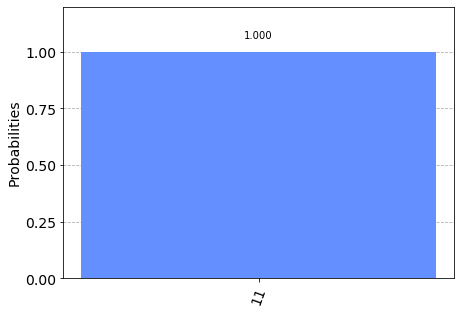

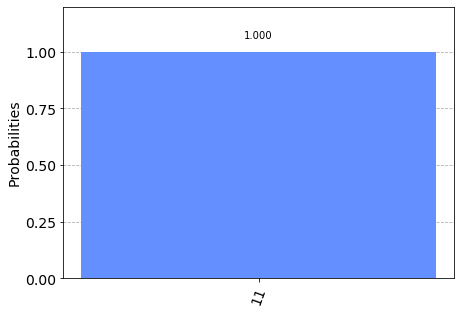

In [52]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)


In [53]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)


ibmqfactory.load_account:WARNING:2022-01-06 13:02:17,936: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_lima


In [54]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)


Job Status: job has successfully run


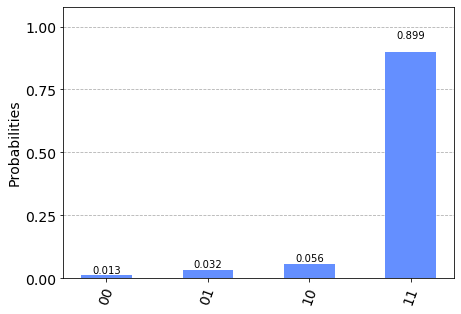

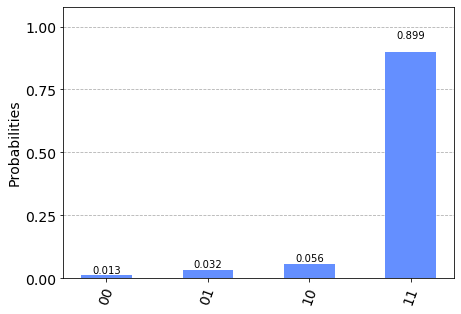

In [55]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)


Avec l'aide de l'algorithme de Grover nous pouvons déterminer avec une certaine certitude assez marquante, l'état que nous recherchons. Dans notre cas, nous avons 90% de chance de tomber sur |11⟩